<a href="https://colab.research.google.com/github/fourmodern/toc_tutorial_colab/blob/main/teachopencadd/t041_molgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MolGen Tutorial**

MolGen은 다양한 분자 생성 및 변환 작업을 수행하기 위한 통합 프레임워크로, 사전 학습된 분자 생성 모델들을 기반으로 분자 디자인, 약물 발견, 화합물 최적화 등을 지원합니다. 이 프레임워크는 최신 딥러닝 아키텍처를 활용하며, 분자 표현으로는 SMILES 및 SELFIES를 지원하여 다양한 분자 표현 작업을 수행할 수 있습니다.

### **지원되는 주요 기능**

MolGen은 여러 분자 생성 및 변환 작업을 수행할 수 있도록 다양한 모델을 통합하고 있으며, 다음과 같은 특징을 가지고 있습니다:
- **다양한 입력 포맷 지원**: SMILES, SELFIES 등의 분자 표현을 지원하여 분자 데이터를 효과적으로 처리할 수 있습니다.
- **Fine-Tuning 지원**: MolGen은 다양한 데이터셋으로 모델을 fine-tuning하여 특정 분자 생성 및 변환 작업에 최적화할 수 있습니다.
- **Deep Learning 통합**: 최신 딥러닝 모델을 활용하여 분자 생성 작업을 수행하며, DeepSpeed와 Hugging Face `transformers` 라이브러리와의 통합을 지원합니다.

### **Citation**

MolGen을 사용하거나 참고하는 연구를 진행할 경우, 다음과 같이 인용할 수 있습니다:

```bibtex
@article{fang2022molt5,
  title={MolGen: A Pre-trained Generative Model for Molecular Generation and Optimization},
  author={Fang, Xiaomin and Wu, Hongyi and Zeng, Xiantao and Chen, Junqi and Song, Jiawei and Yang, Huanqin and Shen, Yuhu},
  journal={arXiv preprint arXiv:2204.11817},
  year={2022}
}

## 0. **Prerequisites**

In [ ]:
!pip install -q transformers datasets rdkit selfies

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


## **1.Molecule Generation (Before Fine-Tuning)**

### 1.1 Import Required Libraries and Load MolGen Model

Hugging Face에서 MolGen 모델을 불러옵니다.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import selfies as sf
import torch

# Load the MolGen-large model and tokenizer from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("zjunlp/MolGen-large")
model = AutoModelForCausalLM.from_pretrained("zjunlp/MolGen-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/13.0 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.97k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/990 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

### 1.2 Converting SMILES to SELFIES and Generating Molecules

SMILES를 SELFIES로 변환한 후 모델을 통해 분자를 생성합니다.

In [ ]:
# Example SMILES input
smiles_input = "CCO"  # Ethanol as an example

# Convert SMILES to SELFIES
selfies_input = sf.encoder(smiles_input)

# Function to generate molecules using SELFIES
def generate_molecules_from_selfies(selfies_input, num_sequences=5):
    input_ids = tokenizer.encode(selfies_input, return_tensors="pt")
    output = model.generate(input_ids, max_length=100, num_return_sequences=num_sequences, do_sample=True)

    # Convert generated SELFIES to SMILES
    generated_selfies = [tokenizer.decode(output_seq, skip_special_tokens=True) for output_seq in output]
    generated_smiles = [sf.decoder(sf_seq) for sf_seq in generated_selfies]

    return generated_smiles

# Generate molecules before fine-tuning
molecules_before = generate_molecules_from_selfies(selfies_input)
print("Generated Molecules (Before Fine-tuning):")
for idx, mol in enumerate(molecules_before):
    print(f"Molecule {idx + 1}: {mol}")


Generated Molecules (Before Fine-tuning):
Molecule 1: CCOC=O
Molecule 2: CCOCC(C)CC(=O)NCCCCC[C@@H1]CCC=[P@@H1]
Molecule 3: CCOC=O
Molecule 4: CCOCCCCNCCCCNCCC(=O)NC[N+1]
Molecule 5: CCOCCCCCl


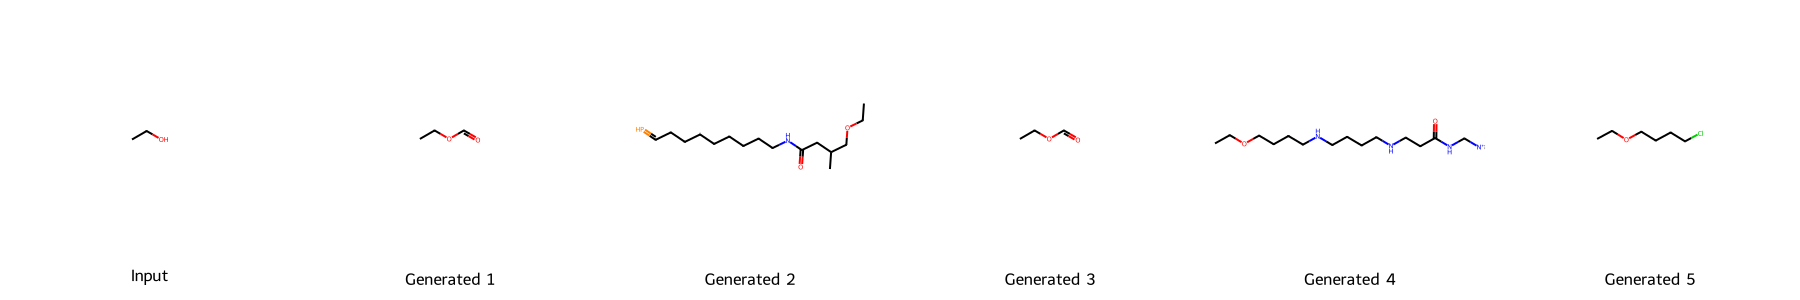

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# 입력된 molecule과 생성된 molecule을 한 줄에 그려주는 함수
def visualize_molecules_in_grid(input_smiles, generated_smiles_list):
    # 입력된 SMILES를 RDKit Mol 객체로 변환
    input_mol = Chem.MolFromSmiles(input_smiles)

    # 생성된 SMILES들을 RDKit Mol 객체로 변환
    generated_mols = [Chem.MolFromSmiles(smiles) for smiles in generated_smiles_list if smiles is not None]

    # 입력된 molecule을 맨 앞에 추가
    all_mols = [input_mol] + generated_mols

    # 각 molecule의 레이블
    legends = ["Input"] + [f"Generated {i + 1}" for i in range(len(generated_mols))]

    # 한 줄에 분자들을 그리는 grid image 생성
    img = Draw.MolsToGridImage(all_mols, molsPerRow=len(all_mols), subImgSize=(300, 300), legends=legends)

    # Display the grid image
    display(img)

# Visualization 실행
visualize_molecules_in_grid(smiles_input, molecules_before)

## **2. Fine-Tuning the Model**

### 2.1 Preparing Dataset for Fine-Tuning

사용자 데이터셋을 SELFIES로 변환하여 fine-tuning에 활용합니다.

In [ ]:
# 다운로드를 위한 URL
file_url = "https://github.com/zjunlp/MolGen/raw/refs/heads/main/moldata/finetune/plogp_test.csv"

# 파일 다운로드
!wget -O plogp_test.csv {file_url}

--2024-09-24 03:38:38--  https://github.com/zjunlp/MolGen/raw/refs/heads/main/moldata/finetune/plogp_test.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zjunlp/MolGen/refs/heads/main/moldata/finetune/plogp_test.csv [following]
--2024-09-24 03:38:38--  https://raw.githubusercontent.com/zjunlp/MolGen/refs/heads/main/moldata/finetune/plogp_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210307 (205K) [text/plain]
Saving to: ‘plogp_test.csv’

plogp_test.csv      100%[===================>] 205.38K  --.-KB/s    in 0.02s   

2024-09-24 03:38:38 (8.25 MB/s) - ‘plogp_test.csv’ saved [210307

In [ ]:
import torch
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForCausalLM
import selfies as sf
from datasets import load_dataset

# GPU 설정 (CUDA가 사용 가능한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# CSV 파일 로드
dataset = load_dataset('csv', data_files="plogp_test.csv")

# 데이터셋 확인
print(dataset['train'][0])  # 첫 번째 데이터 확인

# SMILES를 SELFIES로 변환하는 함수
def smiles_to_selfies(example):
    example["selfies"] = sf.encoder(example["smiles"])
    return example

# Convert SMILES to SELFIES in the dataset
dataset = dataset.map(smiles_to_selfies)

# SELFIES를 토큰화하고 'labels'를 추가하는 함수
def tokenize_selfies_function(examples):
    tokenized_inputs = tokenizer(examples["selfies"], padding="max_length", truncation=True)
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()  # labels 추가
    return tokenized_inputs

# 데이터셋을 토큰화
tokenized_dataset = dataset.map(tokenize_selfies_function, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

{'plogp': -8.211044222801522, 'smiles': 'C[C@@H](C(=O)NC1CCCC1)N1CC[NH+](C2CCCCCCC2)CC1', 'selfies': '[C][C@@H1][Branch1][=N][C][=Branch1][C][=O][N][C][C][C][C][C][Ring1][Branch1][N][C][C][NH1+1][Branch1][O][C][C][C][C][C][C][C][C][Ring1][Branch2][C][C][Ring1][=C]'}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

### 2.2 Performing Fine-Tuning

In [ ]:
# 3. TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,                    # 에포크 수 (필요에 따라 조정)
    per_device_train_batch_size=2,         # 배치 크기
    gradient_accumulation_steps=4,         # gradient accumulation 사용
    save_steps=20,                         # 모델을 얼마나 자주 저장할지 결정
    save_total_limit=2,                    # 최대 저장할 checkpoint 수
    fp16=True,                             # Mixed Precision 사용
    learning_rate=1e-4,                    # 학습률
    weight_decay=0.0001,                   # 가중치 감소 (weight decay)
    eval_strategy="steps",                 # `evaluation_strategy`를 `eval_strategy`로 변경
    eval_steps=20,                         # 평가를 얼마나 자주 수행할지
    logging_dir='./logs',                  # 로그 디렉터리
    logging_steps=20,                      # 로그를 얼마나 자주 기록할지 결정
)

# 4. Trainer 설정 및 Fine-Tuning 실행
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["train"],
    tokenizer=tokenizer,
)

# 5. Fine-Tuning 수행
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss
20,0.147500,0.001718
40,0.001000,0.000420
60,0.000500,0.000180
80,0.000300,0.000095
100,0.000100,0.000072
120,0.000000,0.000047
140,0.000000,0.000045
160,0.000100,0.000021
180,0.000000,0.000015
200,0.000000,0.000013


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau

TrainOutput(global_step=300, training_loss=0.0099788735609521, metrics={'train_runtime': 860.7101, 'train_samples_per_second': 2.788, 'train_steps_per_second': 0.349, 'total_flos': 2972154278707200.0, 'train_loss': 0.0099788735609521, 'epoch': 3.0})

## **3. After Fine-Tuning Generation and Visualization**

### 3.1 Generating Molecules After Fine-Tuning

Fine-tuning이 완료된 모델을 사용하여 새로운 분자를 생성합니다.

In [ ]:
# GPU가 사용 가능한지 확인하고 모델을 CUDA로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Molecule generation을 위한 수정된 함수
def generate_molecules_from_selfies(selfies_input, num_sequences=5):
    # input_ids를 GPU로 이동
    input_ids = tokenizer.encode(selfies_input, return_tensors="pt").to(device)

    # 모델을 사용해 생성
    output = model.generate(input_ids, max_length=100, num_return_sequences=num_sequences, do_sample=True)

    # 생성된 SELFIES를 SMILES로 변환
    generated_selfies = [tokenizer.decode(output_seq, skip_special_tokens=True) for output_seq in output]
    generated_smiles = [sf.decoder(sf_seq) for sf_seq in generated_selfies]

    return generated_smiles
# Generate molecules after fine-tuning
molecules_after = generate_molecules_from_selfies(selfies_input)
print("Generated Molecules (After Fine-tuning):")
for idx, mol in enumerate(molecules_after):
    print(f"Molecule {idx + 1}: {mol}")

Generated Molecules (After Fine-tuning):
Molecule 1: CCO/SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Molecule 2: CCO\OC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CPPPPPPPPPPPP\[C@]
Molecule 3: CCO[P@@][P@@][P@@][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1]\C\C\C\C\C\C\COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Molecule 4: CCO
Molecule 5: CCOF


### 3.2 Visualizing Changes Using RDKit

RDKit를 사용하여 fine-tuning 전후의 분자를 시각화합니다.

Molecule 1:
SMILES Before: CCOC=O
SMILES After: CCO/SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Before Fine-tuning:


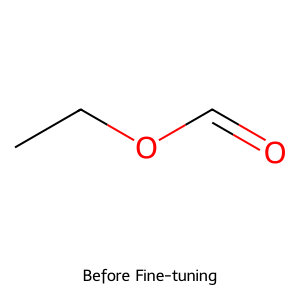

After Fine-tuning:


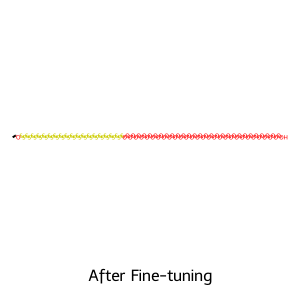



Molecule 2:
SMILES Before: CCOCC(C)CC(=O)NCCCCC[C@@H1]CCC=[P@@H1]
SMILES After: CCO\OC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CPPPPPPPPPPPP\[C@]
Before Fine-tuning:


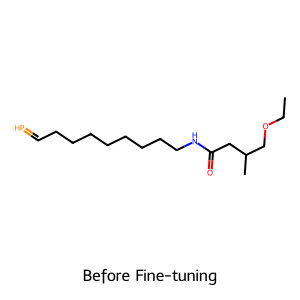

After Fine-tuning:


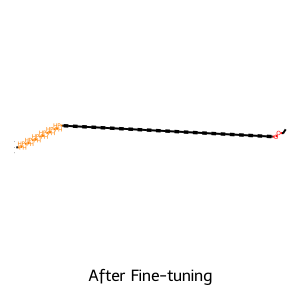



Molecule 3:
SMILES Before: CCOC=O
SMILES After: CCO[P@@][P@@][P@@][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1][N+1]\C\C\C\C\C\C\COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Before Fine-tuning:


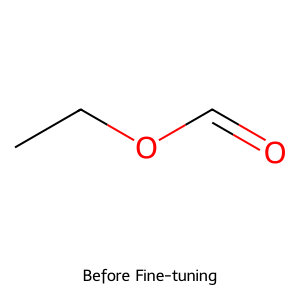

After Fine-tuning:


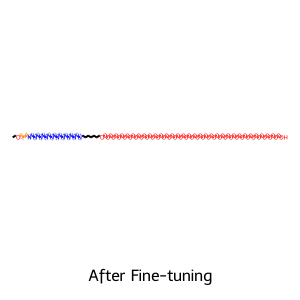



Molecule 4:
SMILES Before: CCOCCCCNCCCCNCCC(=O)NC[N+1]
SMILES After: CCO
Before Fine-tuning:


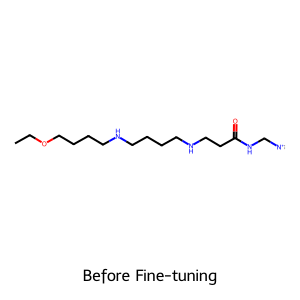

After Fine-tuning:


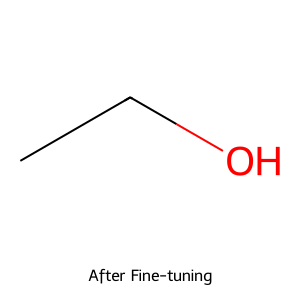



Molecule 5:
SMILES Before: CCOCCCCCl
SMILES After: CCOF
Before Fine-tuning:


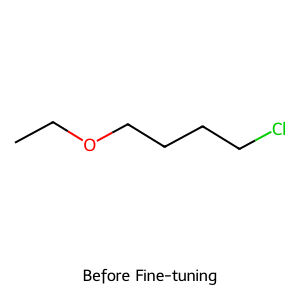

After Fine-tuning:


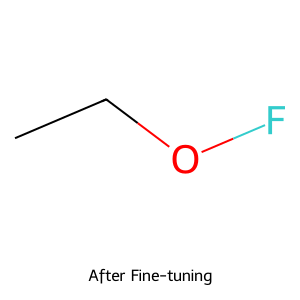

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Convert SMILES to RDKit Mol object
def smiles_to_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

# Function to visualize molecule changes
def visualize_molecule_changes(smiles_before, smiles_after):
    mol_before = smiles_to_mol(smiles_before)
    mol_after = smiles_to_mol(smiles_after)

    if mol_before and mol_after:
        # Draw the molecules side by side
        img_before = Draw.MolToImage(mol_before, size=(300, 300), legend="Before Fine-tuning")
        img_after = Draw.MolToImage(mol_after, size=(300, 300), legend="After Fine-tuning")

        # Display images
        print("Before Fine-tuning:")
        display(img_before)
        print("After Fine-tuning:")
        display(img_after)
    else:
        print("Invalid SMILES strings detected. Unable to generate molecule visualization.")

# Visualize changes for each generated molecule
def visualize_changes(molecules_before, molecules_after):
    for idx in range(len(molecules_before)):
        print(f"Molecule {idx + 1}:")
        print(f"SMILES Before: {molecules_before[idx]}")
        print(f"SMILES After: {molecules_after[idx]}")
        visualize_molecule_changes(molecules_before[idx], molecules_after[idx])
        print("\n")

# Visualize the changes between pre- and post-fine-tuning molecules
visualize_changes(molecules_before, molecules_after)

# **튜토리얼 요약**
1. Molecule Generation (Before Fine-Tuning): SMILES 입력을 SELFIES로 변환하여 모델에 전달하고, 생성된 SELFIES를 다시 SMILES로 변환하여 확인합니다.
2. Fine-Tuning: 데이터셋의 SMILES를 SELFIES로 변환하여 모델을 fine-tuning합니다.
3. After Fine-Tuning Generation 및 Visualization: Fine-tuning 이후 생성된 결과를 시각화하고 구조 변화를 확인합니다.

---

## References

- Fang, Xiaomin, et al. "MolGen: A Pre-trained Generative Model for Molecular Generation and Optimization." *arXiv preprint arXiv:2204.11817*, 2022.
  
  Available at: [MolGen Paper on arXiv](https://arxiv.org/abs/2204.11817)

- MolGen GitHub Repository: [https://github.com/zjunlp/MolGen](https://github.com/zjunlp/MolGen)

- RDKit: Open-source cheminformatics software. Available at: [https://www.rdkit.org](https://www.rdkit.org)

- SELFIES: Krenn, Mario, et al. "SELFIES: a robust representation of semantically constrained graphs with an example application in chemistry." *Machine Learning: Science and Technology*, 2020.
  
  Available at: [https://github.com/aspuru-guzik-group/selfies](https://github.com/aspuru-guzik-group/selfies)

- Hugging Face Transformers: Wolf, Thomas, et al. "Transformers: State-of-the-Art Natural Language Processing." *arXiv preprint arXiv:1910.03771*, 2019.

  Available at: [https://huggingface.co/transformers](https://huggingface.co/transformers)